# import libraries

In [1]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('whitegrid')
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")

import keras
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.layers import Dense, LSTM, Dropout

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

import warnings
warnings.filterwarnings("ignore")

print("libraries was called")

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


libraries was called


In [2]:
data_dir="/kaggle/input/tesla-stock-data-updated-till-28jun2021/TSLA.csv"
df=pd.read_csv(data_dir , parse_dates=True , index_col="Date")

In [3]:
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-06-29,3.800000,5.000000,3.508000,4.778000,4.778000,93831500
2010-06-30,5.158000,6.084000,4.660000,4.766000,4.766000,85935500
2010-07-01,5.000000,5.184000,4.054000,4.392000,4.392000,41094000
2010-07-02,4.600000,4.620000,3.742000,3.840000,3.840000,25699000
2010-07-06,4.000000,4.000000,3.166000,3.222000,3.222000,34334500
...,...,...,...,...,...,...
2022-03-18,874.489990,907.849976,867.390015,905.390015,905.390015,33408500
2022-03-21,914.979980,942.849976,907.090027,921.159973,921.159973,27327200
2022-03-22,930.000000,997.859985,921.750000,993.979980,993.979980,35289500


# Data visualization

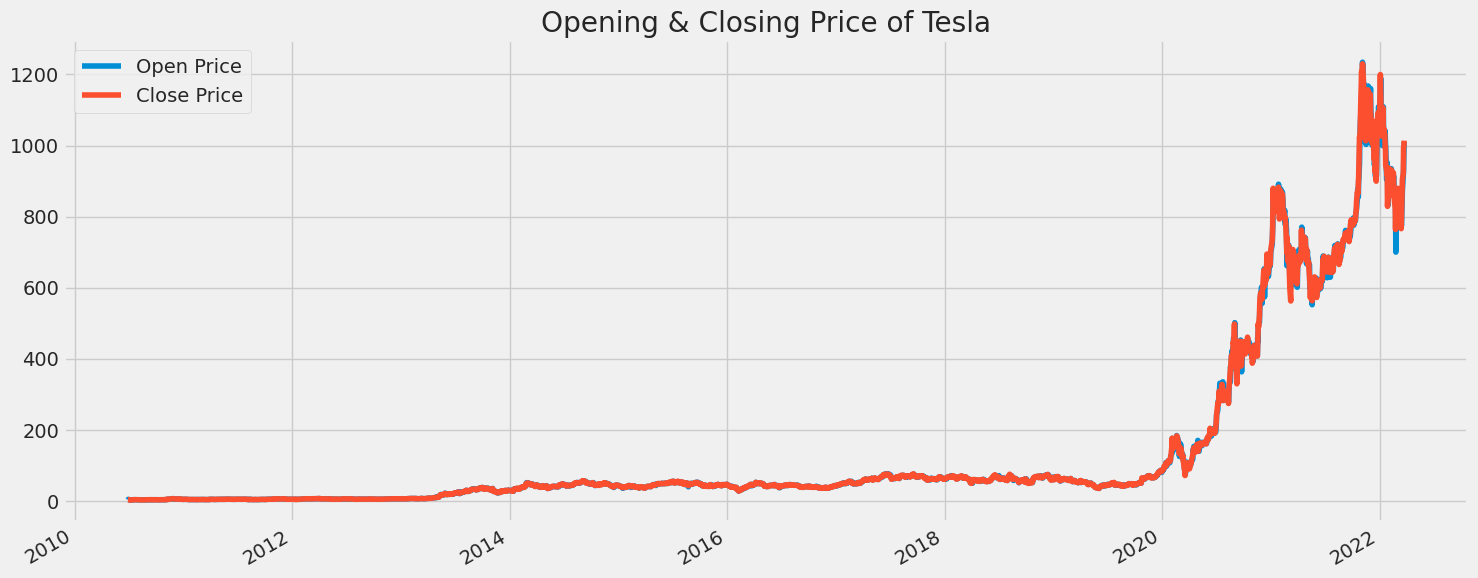

In [4]:
plt.figure(figsize=(15, 6))
df['Open'].plot()
df['Close'].plot()
plt.ylabel(None)
plt.xlabel(None)
plt.title("Opening & Closing Price of Tesla")
plt.legend(['Open Price', 'Close Price'])
plt.tight_layout()
plt.show()

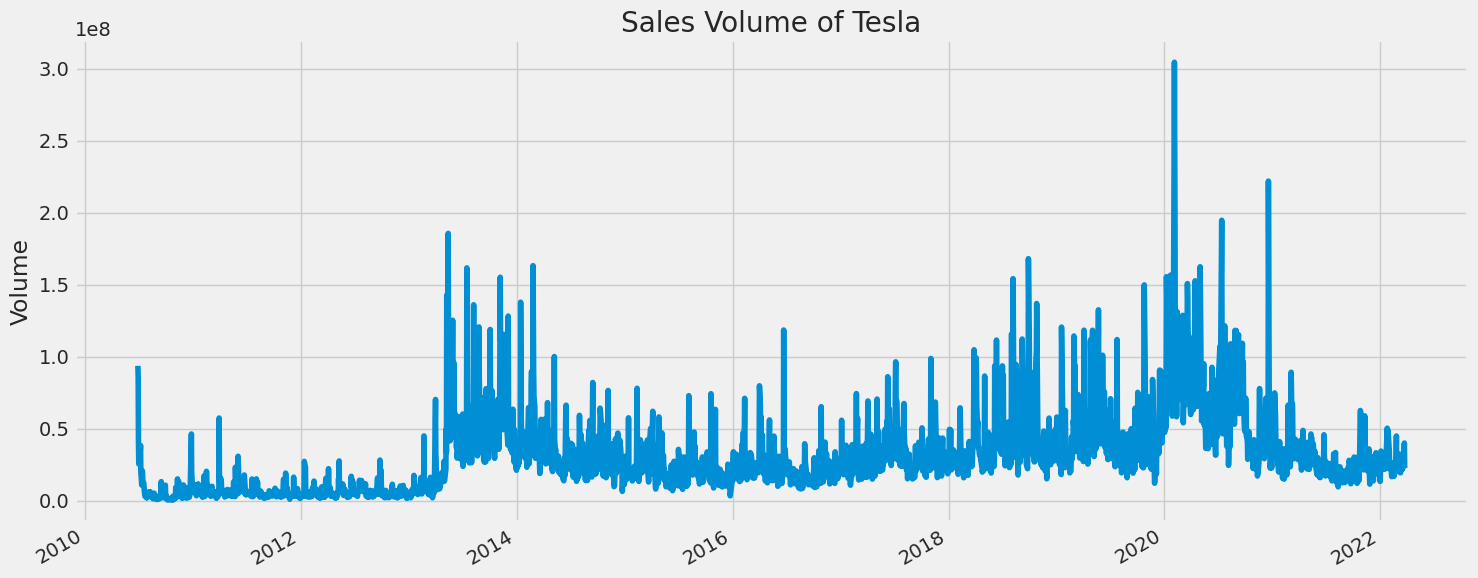

In [5]:
plt.figure(figsize=(15, 6))
df['Volume'].plot()
plt.ylabel('Volume')
plt.xlabel(None)
plt.title("Sales Volume of Tesla")
plt.tight_layout()
plt.show()

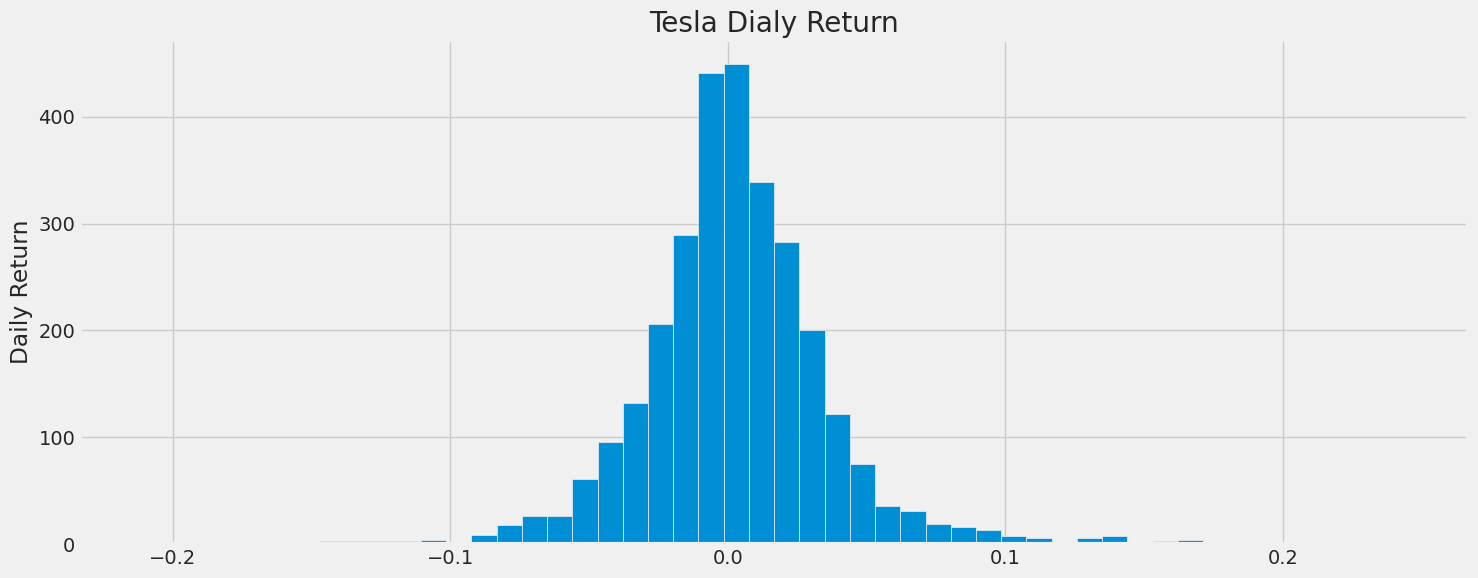

In [6]:
plt.figure(figsize=(15, 6))
df['Adj Close'].pct_change().hist(bins=50)
plt.ylabel('Daily Return')
plt.title(f'Tesla Dialy Return')
plt.tight_layout()
plt.show()

# Data Preprocessing

In [7]:
dataset = df["Close"]  #Choosing Prediction Column
dataset = pd.DataFrame(dataset)
#dataset
data = dataset.values
data.shape

(2956, 1)

In [8]:
dataset

,Close
Date,
2010-06-29,4.778000
2010-06-30,4.766000
2010-07-01,4.392000
2010-07-02,3.840000
2010-07-06,3.222000
...,...
2022-03-18,905.390015
2022-03-21,921.159973
2022-03-22,993.979980


* **Normalizing Data**

In [9]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range= (0, 1))
scaled_data = scaler.fit_transform(np.array(data).reshape(-1, 1))

In [10]:
data

array([[   4.778   ],
       [   4.766   ],
       [   4.392   ],
       ...,
       [ 993.97998 ],
       [ 999.109985],
       [1013.919983]])

* **Splitting the Data**

In [11]:
# 75% to Train , 25% to Test
train_size = int(len(data)*.75) # the train sixze is 75% of all data
test_size = len(data) - train_size

print("Train Size :",train_size,"Test Size :",test_size)

train_data = scaled_data[ :train_size , 0:1 ]  # train size = 2217
test_data = scaled_data[ train_size-60: , 0:1 ] # 60 is time step to link data with each onthers to keep the sequence

Train Size : 2217 Test Size : 739


In [12]:
train_data.shape, test_data.shape


((2217, 1), (799, 1))

* **Creating training set**

In [13]:
# Creating a Training set with 60 time-steps and 1 output
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])

In [14]:
# Convert to numpy array
x_train, y_train = np.array(x_train), np.array(y_train)

In [15]:
# Reshaping the input
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [16]:
x_train.shape , y_train.shape

((2157, 60, 1), (2157,))

In [17]:
model = Sequential([
    LSTM(50, return_sequences= True, input_shape= (x_train.shape[1], 1)),
    LSTM(64, return_sequences= False),
    Dense(32),
    Dense(16),
    Dense(1)
])

model.compile(optimizer= 'adam', loss= 'mse' , metrics= "mean_absolute_error")

In [18]:
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 50)            10400     
                                                                 
 lstm_1 (LSTM)               (None, 64)                29440     
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
Total params: 42,465
Trainable params: 42,465
Non-trainable params: 0
_________________________________________________________________


In [19]:
# Fitting the LSTM to the Training set
callbacks = [EarlyStopping(monitor= 'loss', patience= 10 , restore_best_weights= True)]
history = model.fit(x_train, y_train, epochs= 100, batch_size= 32 , callbacks= callbacks )

Epoch 1/100
68/68 [==============================] - 6s 9ms/step - loss: 7.9453e-05 - mean_absolute_error: 0.0051
Epoch 2/100
68/68 [==============================] - 1s 8ms/step - loss: 5.5903e-06 - mean_absolute_error: 0.0017
Epoch 3/100
68/68 [==============================] - 1s 8ms/step - loss: 4.9897e-06 - mean_absolute_error: 0.0016
Epoch 4/100
68/68 [==============================] - 1s 8ms/step - loss: 5.5292e-06 - mean_absolute_error: 0.0018
Epoch 5/100
68/68 [==============================] - 1s 8ms/step - loss: 4.7663e-06 - mean_absolute_error: 0.0016
Epoch 6/100
68/68 [==============================] - 1s 10ms/step - loss: 5.5428e-06 - mean_absolute_error: 0.0017
Epoch 7/100
68/68 [==============================] - 1s 9ms/step - loss: 6.7549e-06 - mean_absolute_error: 0.0020
Epoch 8/100
68/68 [==============================] - 1s 8ms/step - loss: 4.7749e-06 - mean_absolute_error: 0.0016
Epoch 9/100
68/68 [==============================] - 1s 8ms/step - loss: 4.6296e-06 - m

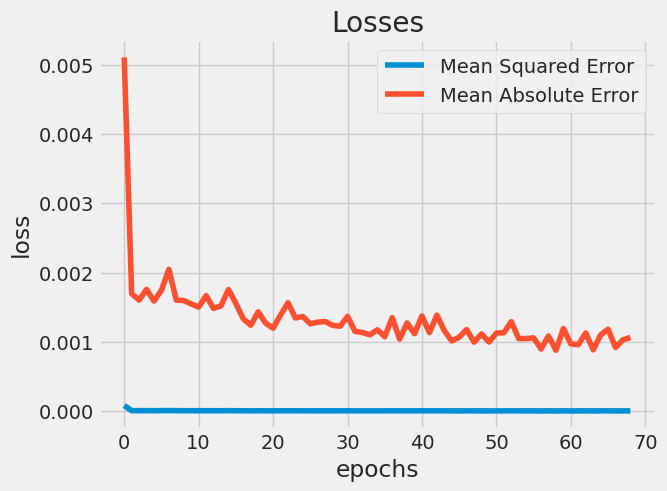

In [20]:
plt.plot(history.history["loss"])
plt.plot(history.history["mean_absolute_error"])
plt.legend(['Mean Squared Error','Mean Absolute Error'])
plt.title("Losses")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [21]:
# Creating a testing set with 60 time-steps and 1 output
x_test = []
y_test = []

for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])
    y_test.append(test_data[i, 0])
x_test, y_test = np.array(x_test), np.array(y_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [22]:
x_test.shape , y_test.shape


((739, 60, 1), (739,))

In [23]:
#inverse y_test scaling
predictions = model.predict(x_test)

#inverse predictions scaling
predictions = scaler.inverse_transform(predictions)
predictions.shape


24/24 [==============================] - 1s 3ms/step


(739, 1)

In [24]:
#inverse y_test scaling
y_test = scaler.inverse_transform([y_test])

RMSE = np.sqrt(np.mean( y_test - predictions )**2).round(2)
RMSE

21.75

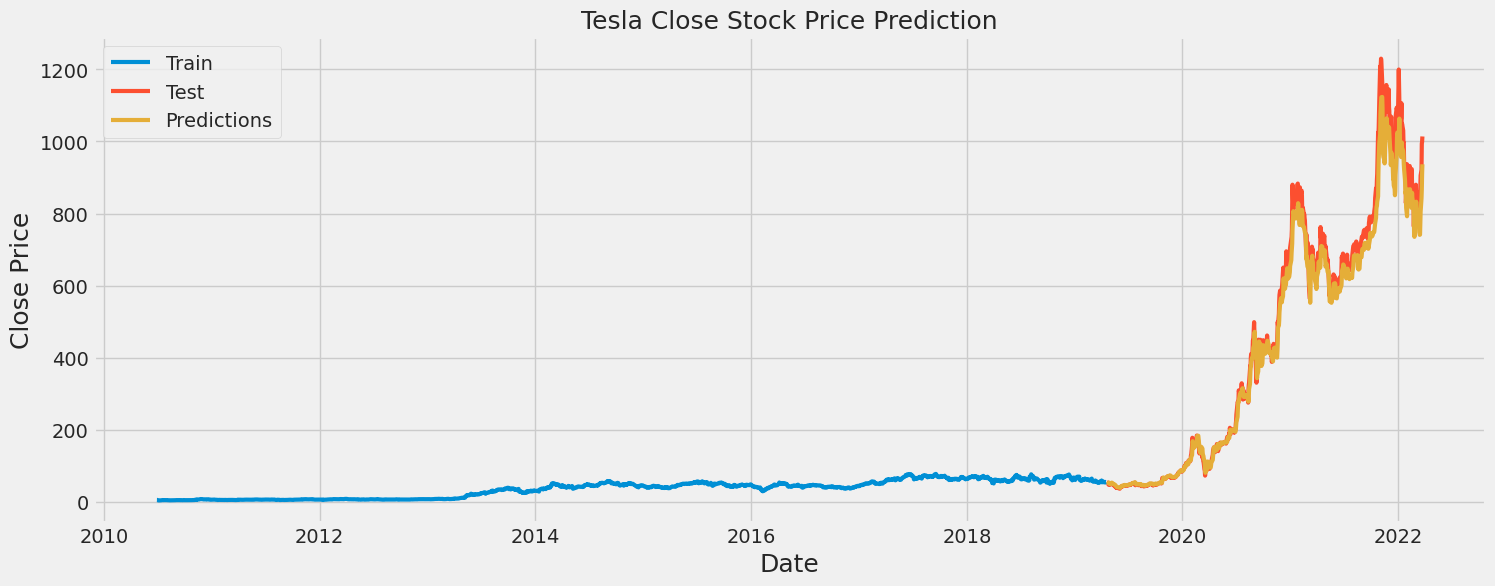

In [25]:
train = dataset.iloc[:train_size , 0:1]
test = dataset.iloc[train_size: , 0:1]
test['Predictions'] = predictions

plt.figure(figsize= (16, 6))
plt.title('Tesla Close Stock Price Prediction', fontsize= 18)
plt.xlabel('Date', fontsize= 18)
plt.ylabel('Close Price', fontsize= 18)
plt.plot(train['Close'], linewidth= 3)
plt.plot(test['Close'], linewidth= 3)
plt.plot(test["Predictions"], linewidth= 3)
plt.legend(['Train', 'Test', 'Predictions'])

In [26]:
from datetime import timedelta
def insert_end(Xin, new_input):
    timestep = 60
    for i in range(timestep - 1):
        Xin[:, i, :] = Xin[:, i+1, :]
    Xin[:, timestep - 1, :] = new_input
    return Xin


In [27]:
future = 30
forcast = []
Xin = x_test[-1 :, :, :]
time = []
for i in range(0, future):
    out = model.predict(Xin, batch_size=5)
    forcast.append(out[0, 0]) 
    print(forcast)
    Xin = insert_end(Xin, out[0, 0]) 
    time.append(pd.to_datetime(df.index[-1]) + timedelta(days=i))
time

1/1 [==============================] - 0s 21ms/step
[0.76094705]
1/1 [==============================] - 0s 21ms/step
[0.76094705, 0.7414126]
1/1 [==============================] - 0s 20ms/step
[0.76094705, 0.7414126, 0.7108395]
1/1 [==============================] - 0s 20ms/step
[0.76094705, 0.7414126, 0.7108395, 0.6767466]
1/1 [==============================] - 0s 19ms/step
[0.76094705, 0.7414126, 0.7108395, 0.6767466, 0.64207137]
1/1 [==============================] - 0s 19ms/step
[0.76094705, 0.7414126, 0.7108395, 0.6767466, 0.64207137, 0.60860085]
1/1 [==============================] - 0s 20ms/step
[0.76094705, 0.7414126, 0.7108395, 0.6767466, 0.64207137, 0.60860085, 0.5775333]
1/1 [==============================] - 0s 21ms/step
[0.76094705, 0.7414126, 0.7108395, 0.6767466, 0.64207137, 0.60860085, 0.5775333, 0.549592]
1/1 [==============================] - 0s 21ms/step
[0.76094705, 0.7414126, 0.7108395, 0.6767466, 0.64207137, 0.60860085, 0.5775333, 0.549592, 0.5250938]
1/1 [=======

[Timestamp('2022-03-24 00:00:00'),
 Timestamp('2022-03-25 00:00:00'),
 Timestamp('2022-03-26 00:00:00'),
 Timestamp('2022-03-27 00:00:00'),
 Timestamp('2022-03-28 00:00:00'),
 Timestamp('2022-03-29 00:00:00'),
 Timestamp('2022-03-30 00:00:00'),
 Timestamp('2022-03-31 00:00:00'),
 Timestamp('2022-04-01 00:00:00'),
 Timestamp('2022-04-02 00:00:00'),
 Timestamp('2022-04-03 00:00:00'),
 Timestamp('2022-04-04 00:00:00'),
 Timestamp('2022-04-05 00:00:00'),
 Timestamp('2022-04-06 00:00:00'),
 Timestamp('2022-04-07 00:00:00'),
 Timestamp('2022-04-08 00:00:00'),
 Timestamp('2022-04-09 00:00:00'),
 Timestamp('2022-04-10 00:00:00'),
 Timestamp('2022-04-11 00:00:00'),
 Timestamp('2022-04-12 00:00:00'),
 Timestamp('2022-04-13 00:00:00'),
 Timestamp('2022-04-14 00:00:00'),
 Timestamp('2022-04-15 00:00:00'),
 Timestamp('2022-04-16 00:00:00'),
 Timestamp('2022-04-17 00:00:00'),
 Timestamp('2022-04-18 00:00:00'),
 Timestamp('2022-04-19 00:00:00'),
 Timestamp('2022-04-20 00:00:00'),
 Timestamp('2022-04-

In [28]:
forcasted_output = np.asanyarray(forcast)   
forcasted_output = forcasted_output.reshape(-1, 1) 
forcasted_output = scaler.inverse_transform(forcasted_output)


forcasted_output = pd.DataFrame(forcasted_output)
date = pd.DataFrame(time)
df_result = pd.concat([date,forcasted_output], axis=1)
df_result.columns = "Date", "Forecasted"

In [29]:
df_result


,Date,Forecasted
0,2022-03-24,936.651855
1,2022-03-25,912.687927
2,2022-03-26,875.182434
3,2022-03-27,833.358948
4,2022-03-28,790.821106
5,2022-03-29,749.761169
6,2022-03-30,711.649048
7,2022-03-31,677.372070
8,2022-04-01,647.318848
9,2022-04-02,621.476562


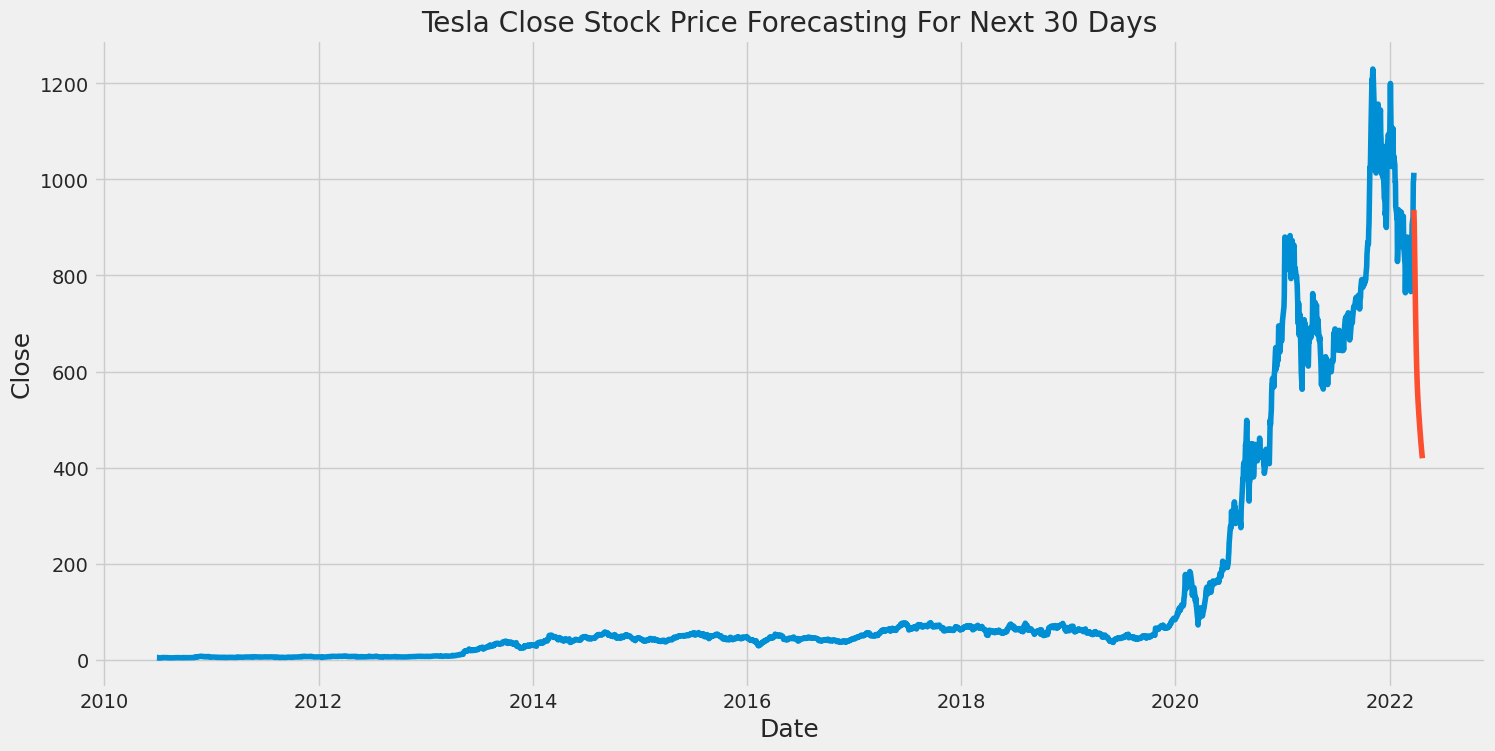

In [30]:
plt.figure(figsize=(16, 8))
plt.title('Tesla Close Stock Price Forecasting For Next 30 Days')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close' ,fontsize=18)
plt.plot(df['Close'])
plt.plot(df_result.set_index('Date')[['Forecasted']])